In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from math import pi

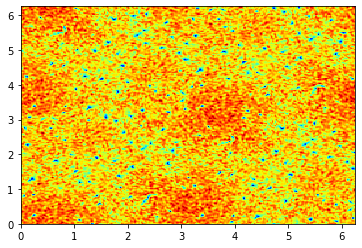

In [2]:
N = 256 # num of rows
M = 256 # num of cols

def read_data(index):
    data_1 = pd.read_csv('waveFuncHelpers/datasetFiles/' + 'data' + str(index) + 'p1.txt', sep=' ', header=None);
    data_2 = pd.read_csv('waveFuncHelpers/datasetFiles/' + 'data' + str(index) + 'p2.txt', sep=' ', header=None);
    data_3 = pd.read_csv('waveFuncHelpers/datasetFiles/' + 'data' + str(index) + 'p3.txt', sep=' ', header=None);
    data_4 = pd.read_csv('waveFuncHelpers/datasetFiles/' + 'data' + str(index) + 'p4.txt', sep=' ', header=None);

    image_data = pd.concat([data_1, data_2, data_3, data_4], axis=0) # Stacking the dataframes
    
    image_data.index = np.arange(0, N*M)
    
    image_data['magnitude'] = np.sqrt(image_data[0]**2 + image_data[1]**2) # Adding a column for 'density'
    image_data['phase'] = np.arctan(image_data[1]/image_data[0]) # Adding a column for 'phase'
    
    image_array = np.array(image_data['magnitude'])
    image_array = image_array.reshape((N, M), order='F') # Using 'Fortran' order to reshape the arrays
    
    x = np.arange(0, 2*pi, 2*pi/N)
    y = np.arange(0, 2*pi, 2*pi/M)
    
    plt.pcolor(x, y, image_array, cmap='jet');
    
    return {'image_data': image_data, 'image_array': image_array}

index = 20
data = read_data(index)

In [4]:
#data = pd.read_csv('waveFuncHelpers/datasetFiles/data8p2.txt', sep=' ', header=None);
data = data['image_data']

phase = np.zeros((N,M));
magnitude = np.zeros((N,M));

for i in range(1, N+1):
   for j in range(1,M+1):
      if((data[1][M*(i-1)+(j-1)]>0)and(data[0][M*(i-1)+(j-1)]>0)):
         phase[i-1,j-1]=np.arctan(data[1][M*(i-1)+(j-1)]/data[0][M*(i-1)+(j-1)]);
      if ((data[1][M*(i-1)+(j-1)]>0)and(data[0][M*(i-1)+(j-1)]<0)):
         phase[i-1,j-1]=np.arctan(data[1][M*(i-1)+(j-1)]/data[0][M*(i-1)+(j-1)])+np.pi;
      if ((data[1][M*(i-1)+(j-1)]<0)and(data[0][M*(i-1)+(j-1)]<0)):
         phase[i-1,j-1]=np.arctan(data[1][M*(i-1)+(j-1)]/data[0][M*(i-1)+(j-1)])+np.pi;
      if ((data[1][M*(i-1)+(j-1)]<0)and(data[0][M*(i-1)+(j-1)]>0)):
         phase[i-1,j-1]=np.arctan(data[1][M*(i-1)+(j-1)]/data[0][M*(i-1)+(j-1)])+2*np.pi;

      magnitude[i-1,j-1]=math.sqrt(data[1][M*(i-1)+(j-1)]**2+data[0][M*(i-1)+(j-1)]**2);
     

In [5]:
y_train = np.zeros((N-1)*(M-1));

for i in range(1, N):
   for j in range(1,M):
    x1 = data[0][M*(i-1)+(j-1)]*data[0][M*(i-1)+j]+data[1][M*(i-1)+(j-1)]*data[1][M*(i-1)+j]
    m1 = magnitude[i-1,j-1]*magnitude[i-1,j]
    x2 = data[0][M*(i-1)+j]*data[0][M*i+j]+data[1][M*(i-1)+j]*data[1][M*i+j]
    m2 = magnitude[i-1,j]*magnitude[i,j]
    x3 = data[0][M*i+(j-1)]*data[0][M*i+j]+data[1][M*i+(j-1)]*data[1][M*i+j]
    m3 = magnitude[i,j]*magnitude[i,j-1]
    x4 = data[0][M*i+(j-1)]*data[0][M*(i-1)+(j-1)]+data[1][M*i+(j-1)]*data[1][M*(i-1)+(j-1)]
    m4 = magnitude[i,j-1]*magnitude[i-1,j-1]
    a = x1/m1
    b = x2/m2
    c = x3/m3
    d = x4/m4
    if(abs(a) > 1):
        a = round(a)
    if(abs(b) > 1):
        b = round(b)
    if(abs(c) > 1):
        c = round(c)
    if(abs(d) > 1):
        d = round(d)
    
    positivexangle=np.arccos(a)
    negativeyangle=np.arccos(b)
    negativexangle=np.arccos(c)
    positiveyangle=np.arccos(d)
    
    internalsum=positivexangle+negativeyangle+negativexangle+positiveyangle;
    
    if internalsum == 2*np.pi:
        if (((phase[i-1,j]>phase[i-1,j-1]) and (phase[i-1,j]-phase[i-1,j-1]<np.pi)) or (((phase[i-1,j]+2*np.pi)>phase[i-1,j-1]) and ((phase[i-1,j]+2*np.pi)-phase[i-1,j-1]<np.pi))):
          y_train[(M-1)*(i-1)+j-1] = 0;
        else:
          y_train[(M-1)*(i-1)+j-1] = 1;
    else:
      y_train[(M-1)*(i-1)+j-1] = 2;

In [6]:
from tensorflow.keras.utils import to_categorical

y_test = y_train

#one-hot encode the target column
y_train = to_categorical(y_train);
y_test = to_categorical(y_test);

In [7]:
y_test[0]

array([0., 0., 1.], dtype=float32)

In [8]:
X_train = np.zeros(((N-1)*(M-1), 2, 2));
X_test = np.zeros(((N-1)*(M-1), 2, 2));

for i in range(0, N):
   for j in range(0, M):
     X_train[(M-1)*(i-1)+(j-1)][0][0]=phase[i-1,j-1]
     X_train[(M-1)*(i-1)+(j-1)][0][1]=phase[i-1,j]
     X_train[(M-1)*(i-1)+(j-1)][1][0]=phase[i,j-1]
     X_train[(M-1)*(i-1)+(j-1)][1][1]=phase[i,j]

In [9]:
X_train = X_train.reshape(-1, 2, 2, 1)
X_test = X_test.reshape(-1, 2, 2, 1)

In [10]:
X_train[0]

array([[[1.67307316],
        [1.71269006]],

       [[1.98653088],
        [1.91606812]]])

In [11]:
model = Sequential();
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu', input_shape=(2,2,1)));
model.add(Conv2D(64, kernel_size=(1, 1), activation='relu'));
model.add(Flatten());
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'));
model.summary()

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']);

#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 1, 128)         640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 64)          8256      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 9,987
Trainable params: 9,987
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2033/2033 [==============================] - 3s 2ms/step - loss: 0.0213 - accuracy: 0.9980 - val_loss: 0.0245

In [12]:
model.predict(X_test[:4])

array([[2.9835571e-16, 3.8313397e-14, 1.0000000e+00],
       [2.9835571e-16, 3.8313397e-14, 1.0000000e+00],
       [2.9835571e-16, 3.8313397e-14, 1.0000000e+00],
       [2.9835571e-16, 3.8313397e-14, 1.0000000e+00]], dtype=float32)

In [13]:
y_test[:4]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [14]:
model.save('trained_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trained_model/assets
